In [49]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy import optimize
from pyproj import Transformer
import random
import time
import cvxpy as cp
# import cplex

In [2]:
# ############### Method 1.1 ##################
# #Using transformer transform XY in to Lo,La and trans. into miles

# #read csv file and get nd-array type X,Y data and get dist_matrix in miles (6988*6988)
# path = os.path.join(os.getcwd(), 'Alachua7000.csv')
# data = pd.read_csv(path, delimiter = ',')
# parcels_location = data[['X','Y']].values

# transformer = Transformer.from_crs(2238, 4326)
# LoLa = []    
# for i in transformer.itransform(parcels_location):
#     LoLa.append(list(i))
# LoLa = np.array(LoLa)

# LoLa[:,0] = LoLa[:,0]%1.1132

# dist_matrix_7000 = squareform(pdist(LoLa, 'minkowski', p=1))
# dist_matrix_7000_in_miles = dist_matrix_7000*62.1371192

In [50]:
############### Method 1.2 ##################
#Using 5280(by QGIS cal.) transform XY into miles (6988*6988)


#read csv file and get nd-array type X,Y data
path = os.path.join(os.getcwd(), 'Alachua7000.csv')
data = pd.read_csv(path, delimiter = ',')
parcels_location = data[['X','Y']].values
parcels_location_in_miles = parcels_location/5280
dist_matrix_7000_in_miles = squareform(pdist(parcels_location_in_miles, 'minkowski', p=1))
print(parcels_location[0,:])
print(parcels_location_in_miles[0,:])

[2656030.266   261117.2003]
[503.03603523  49.45401521]


In [51]:
df1 = data[data['SQFT']>=2000]
df2 = df1[df1['ACRES']>=0.0459]
df3 = df2[df2['STORIES']>0]
df4 = df3[df3['ACTYR']>0]

df4_location = df4[['X','Y']].values
df4_location_in_miles = df4_location/5280

usable_index = df4.index.values

In [75]:
############### Algorithm ##################
############## P-centre problem & b parameter termination ################
start = time.time()
n=200
random.seed(66)

rand_index=random.randint(0,6988)
Q=[]
b=[]
C=[i for i in range(6988)]
iteration_time = []
Q.append(rand_index)
C.remove(rand_index)
for x in range(n-1):
    dist_to_Q=[] 
    dist_to_Q_index=[] 
    for c in C:
        dist=[]
        for q in Q:
            dist.append(dist_matrix_7000_in_miles[c,q])
        dist_to_Q.append(np.min(dist))
        dist_to_Q_index.append(c)
    index=dist_to_Q.index(max(dist_to_Q))
    iteration_time.append(time.time()-start) #Record computing time to every size of Q
    b.append(max(dist_to_Q)) #Record maximum distance b to every size of Q
    Q.append(dist_to_Q_index[index])
    del C[dist_to_Q.index(max(dist_to_Q))]
########## get Q ############

In [78]:
############### Algorithm 1.2 ##################
############## with b parameter ################
start = time.time()
b = 1.5
random.seed(10)

rand_index=random.randint(0,6988)
print('Frist index in Q is {}.'.format(rand_index))
Q=[]
C=[i for i in range(6988)]
Q.append(rand_index)
C.remove(rand_index)
for x in range(7000):
    dist_to_Q=[] 
    dist_to_Q_index=[] 
    for c in C:
        dist=[]
        for q in Q:
            dist.append(dist_matrix_7000_in_miles[c,q])
        dist_to_Q.append(np.min(dist))
        dist_to_Q_index.append(c)
    if max(dist_to_Q) < b:
        print('farthest distance is {}.'.format(max(dist_to_Q)))
        break
    index=dist_to_Q.index(max(dist_to_Q))
    Q.append(dist_to_Q_index[index])        
    del C[dist_to_Q.index(max(dist_to_Q))]
    
end = time.time()
print("Running time for A_1 is:{}".format(end - start))
########## get Q ############

Frist index in Q is 4680.
farthest distance is 1.4955568371212564.
Running time for A_1 is:181.29205536842346


Certain b = 1.9907117424242173
Size of Q: 200


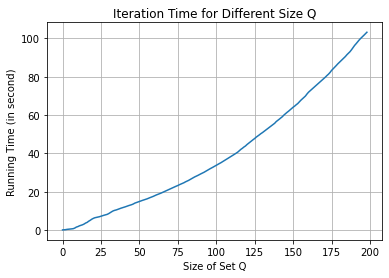

In [23]:
###################################################
############ Analysis and Improvement #############
###################################################
print("Certain b = {}".format(b[-1]))
print("Size of Q: {}".format(len(Q)))


# plt.plot(b)
# plt.title('Relation between size Q and b')
# plt.xlabel('Size of Set Q')
# plt.ylabel('Maximum distance b (miles) to set Q')
# plt.grid()
# plt.savefig('Relation Q_b.pdf')

plt.plot(iteration_time)
plt.title('Iteration Time for Different Size Q')
plt.xlabel('Size of Set Q')
plt.ylabel('Running Time (in second)')
plt.grid()
plt.savefig('Relation Q_Time.pdf')



In [7]:
# ############### Algorithm 1.2 ##################
# ############## with b parameter ################

# b = 1.5
# random.seed(66)

# rand_index=random.randint(0,6988)
# print('Frist index in Q is {}.'.format(rand_index))
# Q=[]
# C=[i for i in range(6988)]
# Q.append(rand_index)
# C.remove(rand_index)
# for x in range(7000):
#     dist_to_Q=[] 
#     dist_to_Q_index=[] 
#     for c in C:
#         dist=[]
#         for q in Q:
#             dist.append(dist_matrix_7000_in_miles[c,q])
#         dist_to_Q.append(np.min(dist))
#         dist_to_Q_index.append(c)
#     if max(dist_to_Q) < b:
#         print('farthest distance is {}.'.format(max(dist_to_Q)))
#         break
#     index=dist_to_Q.index(max(dist_to_Q))
#     Q.append(dist_to_Q_index[index])        
#     del C[dist_to_Q.index(max(dist_to_Q))]
    
# ########## get Q ############

In [79]:
## set treshold to get A
def get_A(Q, usable_index, treshold, parcels_location_in_miles, show_usable_q = False):    
    # get usable site index in Q
    Q = sorted(Q)
    usable_Q = []
    for i in usable_index:
        if i in Q:
            usable_Q.append(i)
    if show_usable_q == True:
        print("usable_Q have {} sites.".format(len(usable_Q)))
        print("usable Q is {}".format(usable_Q))

    # get A distance matrix (in miles)  around(200 * 136) depend on len(Q) and len(usable_Q)
    A_values = np.zeros((len(Q),len(usable_Q)))
    a=0
    for i in Q:
        b=0
        for j in usable_Q:
            A_values[a, b] = np.abs(parcels_location_in_miles[i,0] - parcels_location_in_miles[j,0]) + np.abs(parcels_location_in_miles[i,1] - parcels_location_in_miles[j,1])
            b +=1     
        a +=1


    # Set a treshold to get 0,1 matrix 
    A_01 = np.zeros((len(Q),len(usable_Q)))

    for i in range(len(Q)):
        for j in range(len(usable_Q)):
            if A_values[i, j] <= treshold:###treshold
                A_01[i, j] = 1 
    
    return [A_01, usable_Q]


In [80]:
# Check cell:
test_list = get_A(Q, usable_index, 10, parcels_location_in_miles) # here to set max travel distance 调参 
print(test_list[0].shape[0])
print(test_list[0].shape[1])
print(test_list[1])

321
191
[58, 89, 105, 136, 142, 168, 219, 235, 283, 342, 400, 432, 467, 485, 495, 512, 611, 628, 636, 641, 644, 691, 702, 741, 742, 744, 766, 845, 851, 915, 944, 979, 1004, 1005, 1008, 1073, 1084, 1093, 1103, 1168, 1177, 1199, 1253, 1267, 1328, 1329, 1414, 1462, 1478, 1535, 1542, 1554, 1574, 1598, 1601, 1671, 1683, 1685, 1739, 1768, 1781, 1851, 1863, 1873, 1921, 1927, 2008, 2037, 2088, 2144, 2149, 2163, 2171, 2217, 2223, 2256, 2404, 2593, 2600, 2641, 2665, 2673, 2702, 2775, 2884, 2922, 2930, 3003, 3053, 3252, 3272, 3321, 3339, 3407, 3410, 3451, 3559, 3591, 3602, 3630, 3703, 3835, 3880, 4012, 4026, 4051, 4137, 4156, 4175, 4211, 4229, 4263, 4298, 4312, 4315, 4375, 4394, 4395, 4429, 4430, 4470, 4534, 4538, 4557, 4562, 4618, 4622, 4623, 4680, 4682, 4716, 4734, 4798, 4812, 4856, 4955, 4971, 5000, 5013, 5020, 5168, 5208, 5243, 5247, 5308, 5343, 5364, 5391, 5507, 5598, 5651, 5686, 5712, 5713, 5726, 5770, 5774, 5880, 5896, 5897, 5983, 6005, 6077, 6080, 6083, 6095, 6098, 6123, 6132, 6157, 6158,

In [10]:
# #######TO GET 7000*3900 matrix


# A_full_values = np.zeros((LoLa.shape[0],len(usable_index)))
# p=0
# for i in range(A_full_values.shape[0]):
#     q=0
#     for j in usable_index:
#         A_full_values[p, q] = np.abs(LoLa[i,0] - LoLa[j,0]) + np.abs(LoLa[i,1] - LoLa[j,1])
#         q +=1 
#     p +=1 
# A_full_01 = np.zeros((A_full_values.shape[0], len(usable_index)))

# for i in range(A_full_values.shape[0]):
#     for j in range(A_full_values.shape[1]):
#         if A_full_values[i, j]*62.1371192 <= 20:
#             A_full_01[i, j] = 1 
            
# # run 5 mins

# DataFrame_full = pd.DataFrame(A_full_01)
# DataFrame_full.index = [i for i in range(6988)]
# DataFrame_full.columns = usable_index

# writer = pd.ExcelWriter('matrix_A_full.xlsx')
# DataFrame_full.to_excel(writer,'page_1',float_format='%.1f') # float_format 控制精度

# writer.save()

# # 10 mins

In [69]:
def call_solver(A_01_and_usable_Q, return_opt_value = False):
    # return_opt_value = True to return the optimal value
    # where_solution = True to return the index of these x_i = 1 (used to find number of optimal solution)
    ####### CALL Solver to solve IP
    A_01 = A_01_and_usable_Q[0]
    usable_Q = A_01_and_usable_Q[1]
    # get A(constraints with 0<=x<=1), B. set X to be integer
    n = A_01.shape[1]
    x = cp.Variable(n, integer=True)
    #x = cp.Variable(n, boolean=True)
    A1 = np.array(np.eye(n,n))
    A2 = A1 * (-1)
    B= np.ones(n+n+A_01.shape[0])
    B[:n]=np.zeros(n)
    B[n:n+n]=-B[n:n+n]
    A = np.vstack((A1,A2,A_01))

    constraints = [A @ x >= B]
    objects = cp.Minimize(cp.sum(x))
    prob = cp.Problem(objects,constraints)
    prob.solve(solver=cp.ECOS_BB)##############################################################  RECOMMAND USE "CPLEX"
#     print("\nThe optimal value is", prob.value)
#     print("A solution x is")
#     print(x.value)

    solution=x.value
    drc_index=[usable_Q[i] for i in np.where(solution>0.9)[0]]
    
    if return_opt_value == True:
        return prob.value
#     print('DRC solution index: {}'.format(drc_index))
    return drc_index

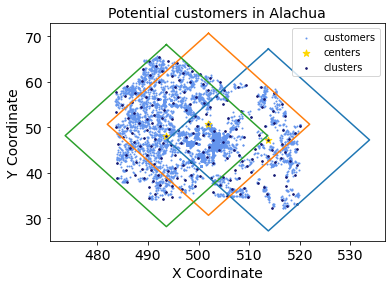

In [72]:
######################################################################################
######################################################################################
############################## GRAPH PART ############################################
######################################################################################
######################################################################################

### For graph, Polt polydren
def gen_poly(x_y, miles):  
    return np.array([[x_y[0], x_y[1]+miles], 
            [x_y[0]+miles, x_y[1]], 
            [x_y[0], x_y[1]-miles], 
            [x_y[0]-miles, x_y[1]],
            [x_y[0], x_y[1]+miles], 
                    ])

### plot graph with n DRC site and 7000 customer and shows the radius

plt.scatter(parcels_location_in_miles[:,0], parcels_location_in_miles[:,1],s=1,c='#6495ED',label='customers',alpha=1)
centers_x=[]
centers_y=[]
cluster_x=[]
cluster_y=[]

drc_index = call_solver(get_A(Q, usable_index, 20, parcels_location_in_miles))  #调参
for i in drc_index:
    centers_x.append(parcels_location_in_miles[i,0])
    centers_y.append(parcels_location_in_miles[i,1])                   
    x_y=np.array([parcels_location_in_miles[i,0],parcels_location_in_miles[i,1]])
    poly_pts=gen_poly(x_y, 20)   # 调参

    plt.plot(poly_pts[:,0],poly_pts[:,1])

    
plt.scatter(centers_x,centers_y,s=50,marker='*',c='#FFD700',alpha=1,label='centers')

for i in Q:
    cluster_x.append(parcels_location_in_miles[i,0])
    cluster_y.append(parcels_location_in_miles[i,1]) 

plt.scatter(cluster_x,cluster_y,s=10,marker='.',c='#191970',alpha=1,label='clusters')    


plt.tick_params(axis='both',which='major',labelsize=14)
plt.title('Potential customers in Alachua',fontsize=14)
plt.xlabel('X Coordinate',fontsize=14)
plt.ylabel('Y Coordinate',fontsize=14)
plt.legend()
plt.savefig('Location_original_sol_20r_p_cen.pdf')



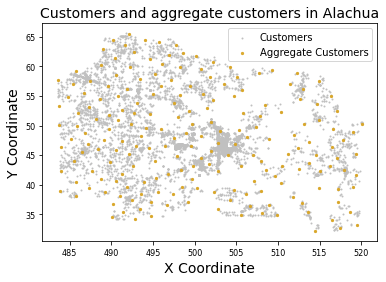

In [17]:
######################################################################################
######################################################################################
############################## GRAPH PART ############################################
######################################################################################
######################################################################################

#plot customers and aggregrated customers
parcels = data.copy()
Q_location_in_miles=parcels_location_in_miles[Q]
plt.scatter(parcels_location_in_miles[:,0], parcels_location_in_miles[:,1],s=1,c='#C0C0C0',alpha=1,label='Customers')
plt.scatter(Q_location_in_miles[:,0],Q_location_in_miles[:,1],s=5,c='#DAA520',alpha=0.9,label='Aggregate Customers')
plt.tick_params(axis='both',which='major',labelsize=14)
plt.title('Customers and aggregate customers in Alachua',fontsize=14)
plt.xlabel('X Coordinate',fontsize=14)
plt.ylabel('Y Coordinate',fontsize=14)
plt.tick_params(labelsize=8)
plt.legend()
plt.savefig('Location_Aggregated.pdf')


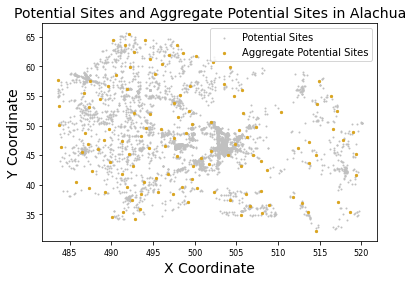

In [18]:
######################################################################################
######################################################################################
############################## GRAGH PART ############################################
######################################################################################
######################################################################################

#plot  Potential Sites and Aggregate Potential Sites 

Q = sorted(Q)
usable_Q = []
for i in usable_index:
    if i in Q:
        usable_Q.append(i)
Q_usable_parcels=parcels_location_in_miles[usable_Q]
plt.scatter(df4_location_in_miles[:,0],df4_location_in_miles[:,1],s=1,c='#C0C0C0',alpha=1,label='Potential Sites')
plt.scatter(Q_usable_parcels[:,0],Q_usable_parcels[:,1],s=5,c='#DAA520',alpha=1,label='Aggregate Potential Sites')
plt.tick_params(axis='both',which='major',labelsize=14)
plt.title('Potential Sites and Aggregate Potential Sites in Alachua',fontsize=14)
plt.xlabel('X Coordinate',fontsize=14)
plt.ylabel('Y Coordinate',fontsize=14)
plt.tick_params(labelsize=8)
plt.legend()
plt.savefig('Location_Aggregated_usable_site.pdf')



In [81]:
######################################################################################
######################################################################################
############################## TABLE PART ############################################
######################################################################################
######################################################################################


DRC_index_10 = call_solver(get_A(Q, usable_index, 10, parcels_location_in_miles))
DRC_index_15 = call_solver(get_A(Q, usable_index, 15, parcels_location_in_miles))
DRC_index_20 = call_solver(get_A(Q, usable_index, 20, parcels_location_in_miles))

def get_measrues(DRC_index, dist_matrix_7000_in_miles, treshold):
    
    dist_information = dist_matrix_7000_in_miles[DRC_index,:]
    dist_to_nearest = dist_information.min(axis=0)
    MTD = dist_to_nearest.max() # Maximum travel distance (miles)
    ATD = np.average(dist_to_nearest) # Average travel distance (miles)
    percent_within = dist_to_nearest[dist_to_nearest<=treshold].shape[0]/dist_to_nearest.shape[0]
    ex_matrix = dist_to_nearest[dist_to_nearest>treshold]-treshold
    if ex_matrix.shape[0] == 0:
        ex_aver = 0
    else:
        ex_aver = ex_matrix.mean()
    return np.array([MTD, ATD, percent_within, ex_aver])

measrues_in_10 = get_measrues(DRC_index_10, dist_matrix_7000_in_miles, 10)
measrues_in_15 = get_measrues(DRC_index_15, dist_matrix_7000_in_miles, 15)
measrues_in_20 = get_measrues(DRC_index_20, dist_matrix_7000_in_miles, 20)

table_matrix = np.vstack((measrues_in_10,measrues_in_15,measrues_in_20)).T

In [82]:
######################################################################################
######################################################################################
################################### Table 1 ##########################################
######################################################################################
######################################################################################
print('Choosen travel limit radius:              10 miles   |   15 miles   |   20 miles')

print('Maximum travel distance (miles):          {:.4}          {:.4}          {:.4}'.format(table_matrix[0,0], table_matrix[0,1], table_matrix[0,2]))
print('Average travel distance (miles):          {:.4}          {:.4}          {:.4}'.format(table_matrix[1,0], table_matrix[1,1], table_matrix[1,2]))
print('% parcels within travel limit ') 
print('radius of a centre:                       {:.4}         {:.4}         {:.4}'.format(table_matrix[2,0], table_matrix[2,1], table_matrix[2,2]))
print('Average distance in excess of travel-')
print('limit for parcels farther from any')
print('center than the travel limit (miles):     {:.4}         {:.4}         {:.4}'.format(table_matrix[3,0], table_matrix[3,1], table_matrix[3,2]))

Choosen travel limit radius:              10 miles   |   15 miles   |   20 miles
Maximum travel distance (miles):          10.31          15.27          19.93
Average travel distance (miles):          6.222          7.921          8.907
% parcels within travel limit 
radius of a centre:                       0.999         0.9997         1.0
Average distance in excess of travel-
limit for parcels farther from any
center than the travel limit (miles):     0.1641         0.2119         0.0


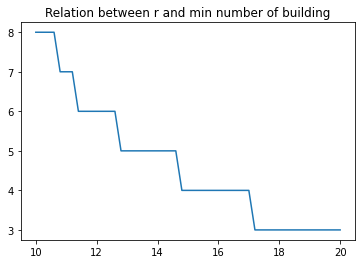

In [19]:
######################################################################################
######################################################################################
##################### Analysis & Find All Optimal Solution ###########################
######################################################################################
######################################################################################

# This cell will cost around 3 mmins
r = 20
s = 0.2
r_list = []
num_of_building = []

while r > 10:
    num_of_building.append(call_solver(get_A(Q, usable_index, r, parcels_location_in_miles), return_opt_value = True))
    r_list.append(r)
    r = r - s
#     print('r = {} finished'.format(r))



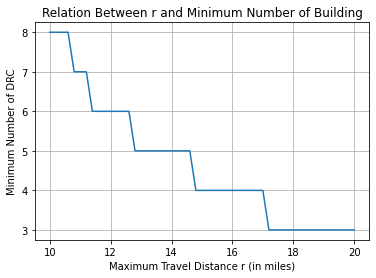

In [25]:
plt.plot(r_list,num_of_building)
plt.title('Relation Between r and Minimum Number of Building')
plt.xlabel('Maximum Travel Distance r (in miles)')
plt.ylabel('Minimum Number of DRC')
plt.grid()
plt.savefig('r with opt value.pdf')

In [18]:
print(r_list[14])
print(num_of_building[14])
print(num_of_building[15])

17.20000000000001
3.0000000627704972
4.000002688469197


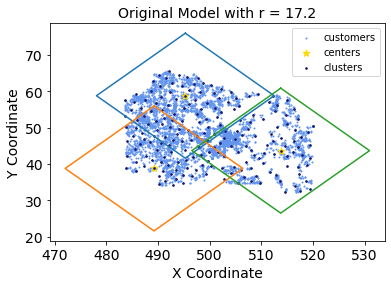

In [32]:
# Let's try r = 17.2
# From graph part:

### plot graph with n DRC site and 7000 customer and shows the radius

plt.scatter(parcels_location_in_miles[:,0], parcels_location_in_miles[:,1],s=1,c='#6495ED',label='customers',alpha=1)
centers_x=[]
centers_y=[]
cluster_x=[]
cluster_y=[]

r = 17.2

drc_index = call_solver(get_A(Q, usable_index, r, parcels_location_in_miles))  #调参
for i in drc_index:
    centers_x.append(parcels_location_in_miles[i,0])
    centers_y.append(parcels_location_in_miles[i,1])                   
    x_y=np.array([parcels_location_in_miles[i,0],parcels_location_in_miles[i,1]])
    poly_pts=gen_poly(x_y, r)   # 调参

    plt.plot(poly_pts[:,0],poly_pts[:,1])
plt.scatter(centers_x,centers_y,s=50,marker='*',c='#FFD700',alpha=1,label='centers')

for i in Q:
    cluster_x.append(parcels_location_in_miles[i,0])
    cluster_y.append(parcels_location_in_miles[i,1]) 

plt.scatter(cluster_x,cluster_y,s=10,marker='.',c='#191970',alpha=1,label='clusters')    


plt.tick_params(axis='both',which='major',labelsize=14)
plt.title('Original Model with r = 17.2',fontsize=14)
plt.xlabel('X Coordinate',fontsize=14)
plt.ylabel('Y Coordinate',fontsize=14)
plt.legend()
plt.savefig('Location_original_sol_17_2r.pdf')

## still perform bad

In [27]:
# To find number of opt solution under r = 17.2
r = 17.2
usable_index_improve = usable_index.copy()

Q = sorted(Q)
usable_Q = []
for i in usable_index:
    if i in Q:
        usable_Q.append(i)
# print(len(Q))

for i in range(3):
    Q_1 = Q.copy()
    usable_index_improve = usable_index.copy() #initialize
    
    glb_index = call_solver(get_A(Q_1, usable_index_improve, r, parcels_location_in_miles))
    print("For a original solution: {}".format(glb_index))
 
    usable_index_improve = np.delete(usable_index_improve,np.where(usable_index_improve==glb_index[i])) # remove 1/3 solution
    Q_1 = np.delete(Q_1,np.where(Q_1==glb_index[i]))
    
    glb_index = call_solver(get_A(Q_1, usable_index_improve, r, parcels_location_in_miles))
    print("Solution when we remove one availble site:{}".format(glb_index))
    if len(glb_index) > 3:
        print("Oh!, We can't remove this site.")
        
# The result shows the optimal solution is unique. But  this solution perform bad, Why?
# This is due to our aggregation 

For a original solution: [4351, 4856, 5364]
Solution when we remove one availble site:[4856, 5364, 5821, 6190]
Oh!, We can't remove this site.
For a original solution: [4351, 4856, 5364]
Solution when we remove one availble site:[860, 3646, 4482, 4712]
Oh!, We can't remove this site.
For a original solution: [4351, 4856, 5364]
Solution when we remove one availble site:[860, 2434, 4222, 5686]
Oh!, We can't remove this site.


In [29]:
# To find ROUND number of opt solution under r = 20
# By a stochastic method: randomly remove one optimal location and do more than once replication
The_solutions = []
r = 20

Q = sorted(Q)
usable_Q = []
for i in usable_index:
    if i in Q:
        usable_Q.append(i)

Q_improve = Q.copy()

for i in range(4): # Try different number of process, more replications will get more solutions
    #initialize
    Q_improve = Q.copy()
    usable_index_improve = usable_index.copy()
    glb_index = call_solver(get_A(Q_improve, usable_index_improve, r, parcels_location_in_miles))
    k = 0
    while len(glb_index) == 3:
        k = k + 1
        randnum = random.randint(0,2)
#         print("Now delete {}".format(glb_index[randnum]))
        usable_index_improve = np.delete(usable_index_improve,np.where(usable_index_improve==glb_index[randnum])) # remove 1/3 solution
        Q_improve = np.delete(Q_improve,np.where(Q_improve==glb_index[randnum]))
        
        glb_index = call_solver(get_A(Q_improve, usable_index_improve, r, parcels_location_in_miles))
#         print("now Q is:",Q_improve)
        if len(glb_index) == 3:
            print("Added one new solution {} to the list.".format(glb_index))
            The_solutions.append(glb_index)
        else:
            print("This stochastic process generate {} new solutions".format(k))
        
        if k > 120: #threshold to avoid infinite loop
            break

Added one new solution [268, 3097, 4367] to the list.
Added one new solution [3097, 4120, 4367] to the list.
Added one new solution [3097, 4211, 5163] to the list.
Added one new solution [4367, 5168, 5248] to the list.
Added one new solution [103, 2434, 3674] to the list.
Added one new solution [4367, 5364, 5800] to the list.
Added one new solution [3679, 3811, 6177] to the list.
Added one new solution [5364, 5814, 5821] to the list.
Added one new solution [4277, 5163, 6190] to the list.
Added one new solution [174, 943, 6792] to the list.
Added one new solution [1329, 3679, 5764] to the list.
Added one new solution [20, 1768, 3646] to the list.
Added one new solution [5248, 5574, 6190] to the list.
Added one new solution [3055, 3646, 4277] to the list.
Added one new solution [3514, 5574, 6792] to the list.
Added one new solution [1428, 3514, 6792] to the list.
Added one new solution [3514, 3518, 3872] to the list.
Added one new solution [20, 5770, 6190] to the list.
Added one new solu

In [38]:
Unique_Sols = np.unique(np.array(The_solutions), axis=0)
print("We total have at least {} different solutions.".format(Unique_Sols.shape[0]+1)) # Last attempt: 74 unique opt solutions

We total have at least 75 different solutions.


In [41]:
######################################################################################
######################################################################################
########################## Model 2 (Maximum Cover Problem) ############################
######################################################################################
######################################################################################

def call_solver_2(A_01_and_usable_Q, p=3,return_opt_value = False):
    # return_opt_value = True to return the optimal value
    ####### CALL Solver to solve IP
    A_01 = A_01_and_usable_Q[0]
    usable_Q = A_01_and_usable_Q[1]
    # number of facilities
    num_of_building = p
    
    # get A(constraints with 0<=x<=1), B. set X to be integer, Ax>=z
    n = A_01.shape[1]
    m =  A_01.shape[0]
    x = cp.Variable(n, integer=True)
    z = cp.Variable(m, integer=True)
    A1 = np.array(np.eye(n,n))
    A2 = A1 * (-1)
    B = np.ones(n+n)
    B[:n] = np.zeros(n)
    B[n:n+n] = -B[n:n+n]
    A = np.vstack((A1,A2))
    # combine 4 constraints
    constraints = [A @ x >=B,A_01 @ x >=z,cp.sum(x)==num_of_building,z>=np.ones(m)] 
    objects = cp.Maximize(cp.sum(z))
    prob = cp.Problem(objects,constraints)
    prob.solve(solver = cp.ECOS_BB)##############################################################  RECOMMAND USE "CPLEX"

    solution2=x.value
    drc_index2=[usable_Q[i] for i in np.where(solution2>0.9)[0]]
#     print('Optimal Value is: {}'.format(prob.value))
    if return_opt_value == True:
        return prob.value
#     print('DRC solution index: {}'.format(drc_index))
    return drc_index2
    

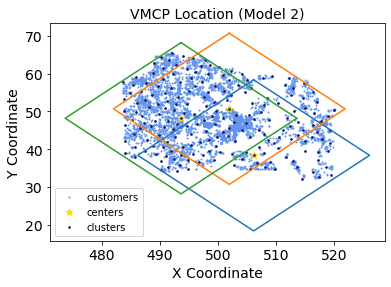

In [47]:
######################################################################################
######################################################################################
############################## GRAPH PART For Model 2 ################################
######################################################################################
######################################################################################

### For graph, Polt polydren
def gen_poly(x_y, miles):  # previous cell has recorded it, but we want metion it again here
    return np.array([[x_y[0], x_y[1]+miles], 
            [x_y[0]+miles, x_y[1]], 
            [x_y[0], x_y[1]-miles], 
            [x_y[0]-miles, x_y[1]],
            [x_y[0], x_y[1]+miles], 
                    ])

### plot graph with n DRC site and 7000 customer and shows the radius

plt.scatter(parcels_location_in_miles[:,0], parcels_location_in_miles[:,1],s=1,c='#6495ED',label='customers',alpha=1)
centers_x=[]
centers_y=[]
cluster_x=[]
cluster_y=[]

drc_index_2 = call_solver_2(get_A(Q, usable_index, 20, parcels_location_in_miles))  #调参
for i in drc_index_2:
    centers_x.append(parcels_location_in_miles[i,0])
    centers_y.append(parcels_location_in_miles[i,1])                   
    x_y=np.array([parcels_location_in_miles[i,0],parcels_location_in_miles[i,1]])
    poly_pts=gen_poly(x_y, 20)   # 调参

    plt.plot(poly_pts[:,0],poly_pts[:,1])
plt.scatter(centers_x,centers_y,s=50,marker='*',c='#FFD700',alpha=1,label='centers')

for i in Q:
    cluster_x.append(parcels_location_in_miles[i,0])
    cluster_y.append(parcels_location_in_miles[i,1]) 

plt.scatter(cluster_x,cluster_y,s=10,marker='.',c='#191970',alpha=1,label='clusters')    

plt.tick_params(axis='both',which='major',labelsize=14)
plt.title('VMCP Location (Model 2)',fontsize=14)
plt.xlabel('X Coordinate',fontsize=14)
plt.ylabel('Y Coordinate',fontsize=14)
plt.legend()
plt.savefig('Location_VMCP_20r.pdf')


In [35]:
# To find number of opt solution under r = 20
r = 20
usable_index_improve = usable_index.copy()

Q = sorted(Q)
usable_Q = []
for i in usable_index:
    if i in Q:
        usable_Q.append(i)


for i in range(3):
    Q_1 = Q.copy()
    usable_index_improve = usable_index.copy() #initialize
    
    glb_index = call_solver_2(get_A(Q_1, usable_index_improve, r, parcels_location_in_miles))
    print("For a original solution: {}".format(glb_index))
 
    usable_index_improve = np.delete(usable_index_improve,np.where(usable_index_improve==glb_index[i])) # remove 1/3 solution
    Q_1 = np.delete(Q_1,np.where(Q_1==glb_index[i]))
    
    glb_index = call_solver_2(get_A(Q_1, usable_index_improve, r, parcels_location_in_miles))
    print("Solution when we remove one availble site:{}".format(glb_index))
    print("-"*20)
    if len(glb_index) > 3:
        print("Oh!, We can't remove this site.")
        
# The result shows the optimal solution is unique. But  this solution perform bad, Why?
# This is due to our aggregation 

Optimal Value is: 384.9997402941192
For a original solution: [3679, 4355, 4367]
Optimal Value is: 378.9992527301765
Solution when we remove one availble site:[4355, 4367, 6483]
--------------------
Optimal Value is: 384.9997402941192
For a original solution: [3679, 4355, 4367]
Optimal Value is: 370.0000479746495
Solution when we remove one availble site:[3097, 4211, 5163]
--------------------
Optimal Value is: 384.9997402941192
For a original solution: [3679, 4355, 4367]
Optimal Value is: 371.00015237661853
Solution when we remove one availble site:[3097, 4211, 5163]
--------------------


In [39]:
######################################################################################
######################################################################################
############################## TABLE PART For Model2 #################################
######################################################################################
######################################################################################

def gen_cover_ratio_1_or_2(model_type, input_by_hand = False, loc_idx = []):
    if input_by_hand == True:
        DRC_index_10 = loc_idx[0]
        DRC_index_15 = loc_idx[1]
        DRC_index_20 = loc_idx[2]
    else:
        if model_type == 1:
            DRC_index_10 = call_solver(get_A(Q, usable_index, 10, parcels_location_in_miles))
            DRC_index_15 = call_solver(get_A(Q, usable_index, 15, parcels_location_in_miles)) 
            DRC_index_20 = call_solver(get_A(Q, usable_index, 20, parcels_location_in_miles))
        elif model_type == 2:
            DRC_index_10 = call_solver_2(get_A(Q, usable_index, 10, parcels_location_in_miles),p=8) # p=8 from previous model's graph
            DRC_index_15 = call_solver_2(get_A(Q, usable_index, 15, parcels_location_in_miles),p=4) # p=4
            DRC_index_20 = call_solver_2(get_A(Q, usable_index, 20, parcels_location_in_miles),p=3)

    def get_measrues_cover_ratio(DRC_index, dist_matrix_7000_in_miles, treshold):

        dist_information = dist_matrix_7000_in_miles[DRC_index,:]
        dist_to_nearest = dist_information.min(axis=0)
        
        sorted_dist_infor = dist_information.copy()
        for i in range(dist_information.shape[1]):
            sorted_dist_infor[:,i] = sorted(dist_information[:,i])
        dist_to_2_nearest = sorted_dist_infor[:2,:].copy()
        dist_to_3_nearest = sorted_dist_infor[:3,:].copy()


        covered_by_al_1 = dist_to_nearest[dist_to_nearest<=treshold].shape[0]/dist_to_nearest.shape[0]
        covered_by_al_2 = dist_to_2_nearest[1,:][dist_to_2_nearest[1,:]<=treshold].shape[0]/dist_to_nearest.shape[0]
        covered_by_al_3 = dist_to_3_nearest[2,:][dist_to_3_nearest[2,:]<=treshold].shape[0]/dist_to_nearest.shape[0]


        return np.array([covered_by_al_1, covered_by_al_2, covered_by_al_3])

    measrues_in_10 = get_measrues_cover_ratio(DRC_index_10, dist_matrix_7000_in_miles, 10)
    measrues_in_15 = get_measrues_cover_ratio(DRC_index_15, dist_matrix_7000_in_miles, 15)
    measrues_in_20 = get_measrues_cover_ratio(DRC_index_20, dist_matrix_7000_in_miles, 20)

    table_matrix = np.vstack((measrues_in_10,measrues_in_15,measrues_in_20)).T
    
    return table_matrix

In [42]:
######################################################################################
######################################################################################
################################### Comparing Tables #################################
######################################################################################
######################################################################################

table_matrix_M1 = gen_cover_ratio_1_or_2(1)
print("Original Model")
print('Choosen travel limit radius:                            10 miles   |   15 miles   |   20 miles')
print('% of parcels covered by at least one centre:             {:.4}         {:.4}         {:.4}'.format(table_matrix_M1[0,0], table_matrix_M1[0,1], table_matrix_M1[0,2]))
print('% of parcels covered by at least two centre:             {:.4}         {:.4}         {:.4}'.format(table_matrix_M1[1,0], table_matrix_M1[1,1], table_matrix_M1[1,2]))
print('% of parcels covered by at least three centre:           {:.4}       {:.4}         {:.4}'.format(table_matrix_M1[2,0], table_matrix_M1[2,1], table_matrix_M1[2,2]))
print('-'*40)
table_matrix_M2 = gen_cover_ratio_1_or_2(2)
print("Maximum covering Model")
print('Choosen travel limit radius:                            10 miles   |   15 miles   |   20 miles')
print('% of parcels covered by at least one centre:             {:.4}         {:.4}         {:.4}'.format(table_matrix_M2[0,0], table_matrix_M2[0,1], table_matrix_M2[0,2]))
print('% of parcels covered by at least two centre:             {:.4}         {:.4}         {:.4}'.format(table_matrix_M2[1,0], table_matrix_M2[1,1], table_matrix_M2[1,2]))
print('% of parcels covered by at least three centre:           {:.4}       {:.4}         {:.4}'.format(table_matrix_M2[2,0], table_matrix_M2[2,1], table_matrix_M2[2,2]))


Original Model
Choosen travel limit radius:                            10 miles   |   15 miles   |   20 miles
% of parcels covered by at least one centre:             0.9991         0.9991         0.9993
% of parcels covered by at least two centre:             0.2155         0.5102         0.7873
% of parcels covered by at least three centre:           0.01274       0.03105         0.4389
----------------------------------------
Maximum covering Model
Choosen travel limit radius:                            10 miles   |   15 miles   |   20 miles
% of parcels covered by at least one centre:             0.9991         0.9991         0.9959
% of parcels covered by at least two centre:             0.2274         0.5102         0.7785
% of parcels covered by at least three centre:           0.01674       0.03105         0.4662


In [28]:
######################################################################################
######################################################################################
########################## Model 3 (Minmum Max Problem) ############################
######################################################################################
######################################################################################

# def call_solver_3(A_01_and_usable_Q, p=3,return_opt_value = False):
#     # return_opt_value = True to return the optimal value
#     ####### CALL Solver to solve IP
#     A_01 = A_01_and_usable_Q[0]
#     usable_Q = A_01_and_usable_Q[1]
#     # number of facilities
#     num_of_building = p
#     # define distance matrix
#     A_values = np.zeros((len(Q),len(usable_Q)))
#     a=0
#     for i in Q:
#         b=0
#         for j in usable_Q:
#             A_values[a, b] = np.abs(parcels_location_in_miles[i,0] - parcels_location_in_miles[j,0]) + np.abs(parcels_location_in_miles[i,1] - parcels_location_in_miles[j,1])
#             b +=1     
#         a +=1


#     # define variable 
#     n = A_values.shape[0]
#     m = A_values.shape[1]
#     X = cp.Variable((n,m),boolean=True)
#     y = cp.Variable(m,boolean=True)
#     z = cp.Variable(1)

#     #define  constraints
#     constraint =[]
#     for i in range(n):
#         for j in range(m):
#             constraint += [X[i,j]<=y[j]]
 
#     for i in range(n):
#         for j in range(m):
#             constraint += [
#                 A_values[i,j]*X[i,j]<=z 
#                 ]      
            
#     #A1 = np.array(np.eye(m,m))
#     #A2 = A1 * (-1)
#     #B = np.ones(m+m)
#     #B[:m] = np.zeros(m)
#     #B[m:m+m] = -B[m:m+m]
#     #A = np.vstack((A1,A2))
    
#     constraint+=  [X@np.ones(m)==np.ones(n)]     
#     constraint+= [cp.sum(y)==num_of_building]
#     #constraint+= [A @ y >=B]
#     # write the objective function
#     objects = cp.Minimize(z)
#     prob = cp.Problem(objects,constraint)
#     prob.solve(solver = cp.ECOS_BB)##############################################################  RECOMMAND USE "CPLEX"
#     print(prob.status)
#     solution3=y.value
#     drc_index3=[usable_Q[i] for i in np.where(solution3>0.9)[0]]

#     if return_opt_value == True:
#         return prob.value
# #     print('DRC solution index: {}'.format(drc_index))
#     return drc_index3
    

E:\Anaconda\envs\cvxpy\lib\site-packages\cvxpy\problems\problem.py:1125: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


infeasible_inaccurate


TypeError: '>' not supported between instances of 'NoneType' and 'float'

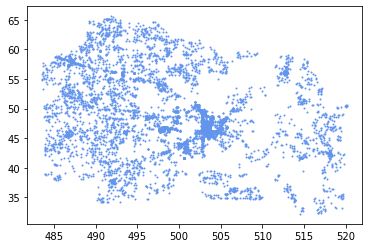

In [29]:
######################################################################################
######################################################################################
############################## GRAPH PART For Model 3 ################################
######################################################################################
######################################################################################

### For graph, Polt polydren
# def gen_poly(x_y, miles):  # previous cell has recorded it, but we want metion it again here
#     return np.array([[x_y[0], x_y[1]+miles], 
#             [x_y[0]+miles, x_y[1]], 
#             [x_y[0], x_y[1]-miles], 
#             [x_y[0]-miles, x_y[1]],
#             [x_y[0], x_y[1]+miles], 
#                     ])

# ### plot graph with n DRC site and 7000 customer and shows the radius

# plt.scatter(parcels_location_in_miles[:,0], parcels_location_in_miles[:,1],s=1,c='#6495ED',label='customers',alpha=1)
# centers_x=[]
# centers_y=[]
# cluster_x=[]
# cluster_y=[]

# drc_index_3 = call_solver_3(get_A(Q, usable_index, 20, parcels_location_in_miles))  #调参
# for i in drc_index_3:
#     centers_x.append(parcels_location_in_miles[i,0])
#     centers_y.append(parcels_location_in_miles[i,1])                   
#     x_y=np.array([parcels_location_in_miles[i,0],parcels_location_in_miles[i,1]])
#     poly_pts=gen_poly(x_y, 20)   # 调参

#     plt.plot(poly_pts[:,0],poly_pts[:,1])
# plt.scatter(centers_x,centers_y,s=50,marker='*',c='#FFD700',alpha=1,label='centers')

# for i in Q:
#     cluster_x.append(parcels_location_in_miles[i,0])
#     cluster_y.append(parcels_location_in_miles[i,1]) 

# plt.scatter(cluster_x,cluster_y,s=10,marker='.',c='#191970',alpha=1,label='clusters')    

# plt.tick_params(axis='both',which='major',labelsize=14)
# plt.title('Potential customers in Alachua',fontsize=14)
# plt.xlabel('X Coordinate',fontsize=14)
# plt.ylabel('Y Coordinate',fontsize=14)
# plt.legend()

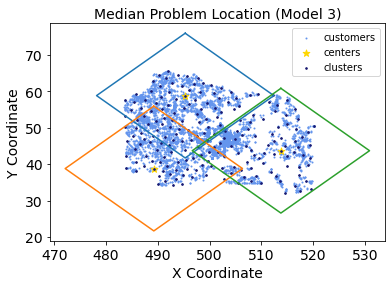

In [48]:
######################################################################################
######################################################################################
############################## GRAPH PART For Model 2 ################################
######################################################################################
######################################################################################

### For graph, Polt polydren
def gen_poly(x_y, miles):  # previous cell has recorded it, but we want metion it again here
    return np.array([[x_y[0], x_y[1]+miles], 
            [x_y[0]+miles, x_y[1]], 
            [x_y[0], x_y[1]-miles], 
            [x_y[0]-miles, x_y[1]],
            [x_y[0], x_y[1]+miles], 
                    ])

### plot graph with n DRC site and 7000 customer and shows the radius

plt.scatter(parcels_location_in_miles[:,0], parcels_location_in_miles[:,1],s=1,c='#6495ED',label='customers',alpha=1)
centers_x=[]
centers_y=[]
cluster_x=[]
cluster_y=[]


###################
A01andusableQ = get_A(Q, usable_index, 20, parcels_location_in_miles)
drc_index_3 = [A01andusableQ[1][68],A01andusableQ[1][80],A01andusableQ[1][90]]
#######################


for i in drc_index_3:
    centers_x.append(parcels_location_in_miles[i,0])
    centers_y.append(parcels_location_in_miles[i,1])                   
    x_y=np.array([parcels_location_in_miles[i,0],parcels_location_in_miles[i,1]])
    poly_pts=gen_poly(x_y, 17.12)   # 调参

    plt.plot(poly_pts[:,0],poly_pts[:,1])
plt.scatter(centers_x,centers_y,s=50,marker='*',c='#FFD700',alpha=1,label='centers')

for i in Q:
    cluster_x.append(parcels_location_in_miles[i,0])
    cluster_y.append(parcels_location_in_miles[i,1]) 

plt.scatter(cluster_x,cluster_y,s=10,marker='.',c='#191970',alpha=1,label='clusters')    

plt.tick_params(axis='both',which='major',labelsize=14)
plt.title('Median Problem Location (Model 3)',fontsize=14)
plt.xlabel('X Coordinate',fontsize=14)
plt.ylabel('Y Coordinate',fontsize=14)
plt.legend()
plt.savefig('Location_MP_sol17_1199.pdf')